In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [15]:
# Find the most recent date in the data set.
recent_data = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_data)

#didn't mean to label it as data but I keep it

('2017-08-23',)


Most recent date in the dataset: 2017-08-23 00:00:00


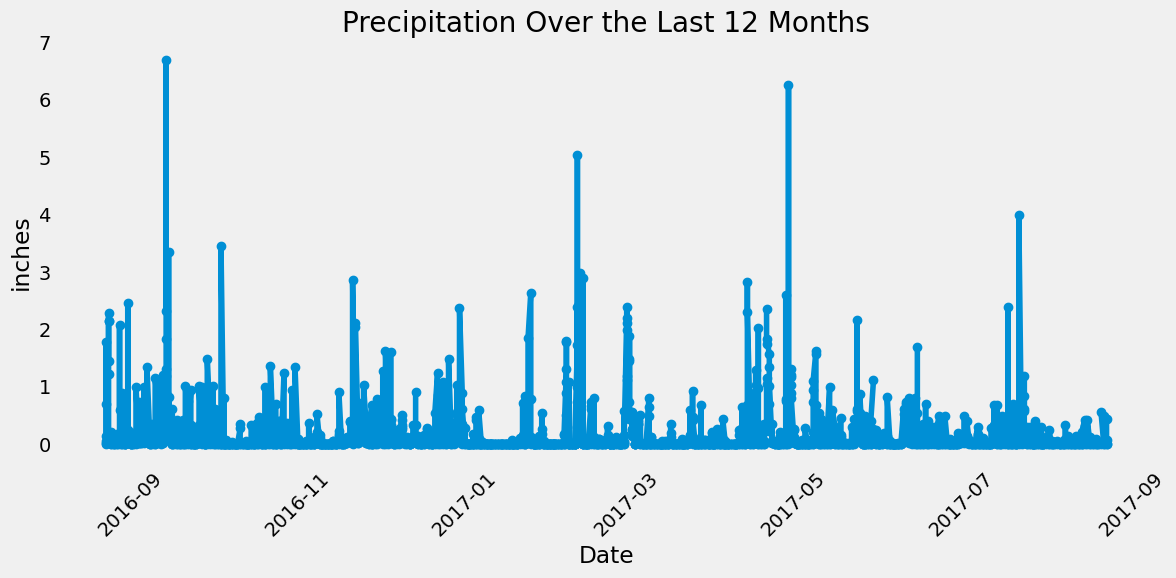

In [53]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_data = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
if recent_data:
    recent_date = pd.to_datetime(recent_data[0])
    print("Most recent date in the dataset:", recent_date)


# Calculate the date one year from the last date in data set.
one_year_ago = recent_date - pd.DateOffset(years=1)
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')
# Perform a query to retrieve the data and precipitation scores
precipitation_query = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= one_year_ago_str).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_query, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])
precipitation_df.sort_values(by='Date', inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(12, 6))
plt.plot(precipitation_df['Date'], precipitation_df['Precipitation'], marker='o')
plt.title('Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('inches')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()



In [55]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df['Precipitation'].describe()
print("Summary Statistics for Precipitation:")
print(summary_stats)


Summary Statistics for Precipitation:
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [58]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.station).count()
print(total_stations)

9


In [64]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

#active_stations = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).desc()).all()
active_stations = session.query(
    Measurement.station,
    func.count(Measurement.station).label('station_count')
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [78]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = active_stations[0][0] if active_stations else None

temperature_stats = session.query(
        func.min(Measurement.tobs).label('min_temp'),
        func.max(Measurement.tobs).label('max_temp'),
        func.avg(Measurement.tobs).label('avg_temp')
    ).filter(Measurement.station == most_active_station_id).all()
print(temperature_stats)


[(54.0, 85.0, 71.66378066378067)]


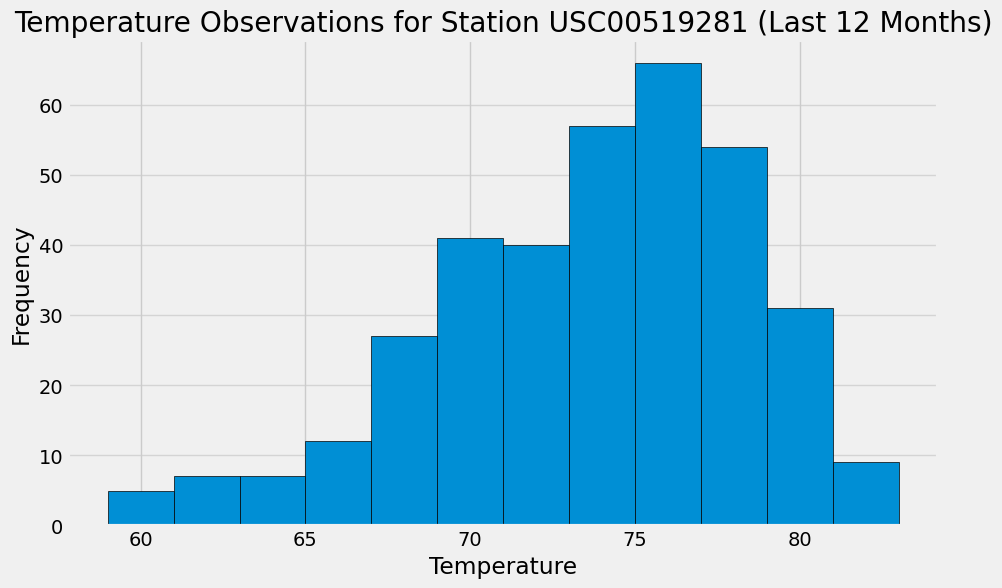

In [89]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_date = session.query(func.max(Measurement.date)).filter(Measurement.station == most_active_station_id).scalar()
last_date = datetime.strptime(last_date, '%Y-%m-%d')
start_date = last_date - timedelta(days=365)

temp_observations = session.query(Measurement.tobs).filter(
    Measurement.station == most_active_station_id,
    Measurement.date >= start_date
    ).all()

temp_data = pd.DataFrame(temp_observations, columns=['Temperature'])

plt.figure(figsize=(10, 6))
plt.hist(temp_data['Temperature'], bins=12, edgecolor='black')
plt.title(f'Temperature Observations for Station {most_active_station_id} (Last 12 Months)')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Close Session

In [90]:
# Close Session
session.close()